In [2]:
library(dplyr)
library(Seurat)
library(Matrix)
library(harmony)
library(stringr)
library(ggplot2)
library(SingleCellExperiment)

In [ ]:
getDistinctColors <- function(n) {
    qual_col_pals <- brewer.pal.info[brewer.pal.info$category == 'qual',]
    col_vector <- unique (unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals))));
    stopifnot (n <= length(col_vector));
    xxx <- col2rgb(col_vector);
    dist_mat <- as.matrix(dist(t(xxx)));
    diag(dist_mat) <- 1e10;
    while (length(col_vector) > n) {
        minv <- apply (dist_mat,1,function(x)min(x));
        idx <- which(minv==min(minv))[1];
        dist_mat <- dist_mat[-idx, -idx];
        col_vector <- col_vector[-idx]
    }
    col_vector
}

tSNE_with_harmony <- function(data.integrated,resolution=0.8, npcs=50,perplexity=30){
    library(harmony)
    data.integrated <- RunPCA(data.integrated, npcs=npcs ,verbose = FALSE,perplexity=perplexity)
    data.integrated <- RunHarmony(data.integrated, group.by.vars = 'orig.ident', verbose = FALSE,plot_convergence = FALSE)
    data.integrated <- RunTSNE(data.integrated, nthreads= 4, max_iter=2000,reduction = 'harmony')
    #data.integrated <- RunUMAP(data.integrated, dims = 1:30, verbose = FALSE, umap.method = 'umap-learn', metric = 'correlation')
    data.integrated <- FindNeighbors(data.integrated, dims = 1:npcs, verbose = FALSE,reduction = 'harmony')
    data.integrated <- FindClusters(data.integrated, resolution=resolution, verbose = FALSE)
    return (data.integrated)
}
                       
# cells->seurat_object
cellcycle <- function(cells) {
    # Read in the expression matrix The first row is a header row, the first column is rownames
    homedir = "/data/share/scRNAseq/results/human_STAD/cellranger_3.1/human_scRNAseq_analysis/pipeline"
    cc_file = paste0(homedir, "/working_data/cell_cycle/nestorawa_forcellcycle_expressionMatrix.txt")
    exp.mat <- read.table(file = cc_file, header = TRUE, 
        as.is = TRUE, row.names = 1)
    # A list of cell cycle markers, from Tirosh et al, 2015, is loaded with Seurat.  We can
    # segregate this list into markers of G2/M phase and markers of S phase
    s.genes <- cc.genes$s.genes
    g2m.genes <- cc.genes$g2m.genes
    cells <- CellCycleScoring(cells, 
                              s.features = s.genes, 
                              g2m.features = g2m.genes)
    return (cells)
}
                   
markers <- function(epi){
    a <- FindAllMarkers(epi, only.pos = TRUE, 
                         min.pct = 0.10, 
                         logfc.threshold = 0.25,
                         test.use="MAST",
                         latent.vars="nFeature_RNA") 
    return (a)
   }

In [4]:
all <- readRDS('./0_integrated_data_normal.rds')

In [15]:
Idents(all) <- 'seurat_clusters'

In [286]:
all <- FindVariableFeatures(all, selection.method = "vst", nfeatures = 4000)
var.genes <- all@assays$RNA@var.features
all.genes <- rownames(all)
all <- ScaleData(all, features = var.genes)#, vars.to.regress="percent.mt")

Centering and scaling data matrix



In [ ]:
all <- tSNE_with_harmony(all, resolution=0.8, npcs=40)

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 7018600)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 7018600)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 7018600)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 7018600)”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


In [16]:
# institution割当
St <- str_detect(all@meta.data$orig.ident,pattern='Stanford')
Tg <- str_detect(all@meta.data$orig.ident,pattern='Tsinghua')
ins <- rep(0,dim(all@meta.data)[1])
ins <- ins + St + 2 * Tg

for (i in 1:length(ins)){
    if (ins[i] == 0) ins[i] = 'UT'
    if (ins[i] == 1) ins[i] = 'Stanford'
    if (ins[i] == 2) ins[i] = "Tsinghua"
}

In [ ]:
all <- RunUMAP(all, reduction = "harmony", dims = 1:40)

In [18]:
Idents(all) <- 'institution'

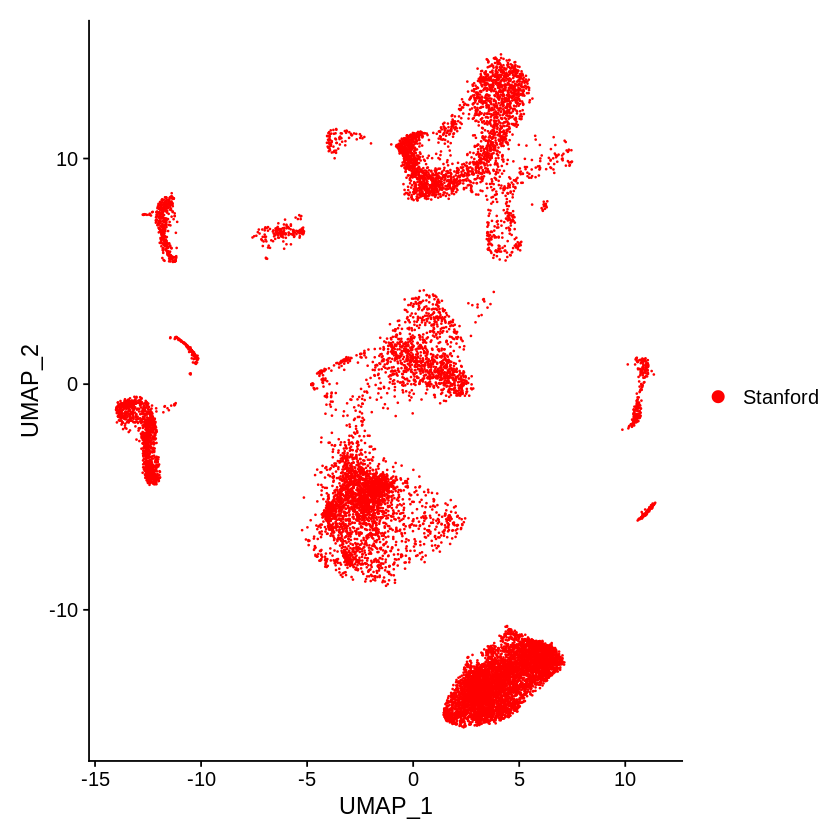

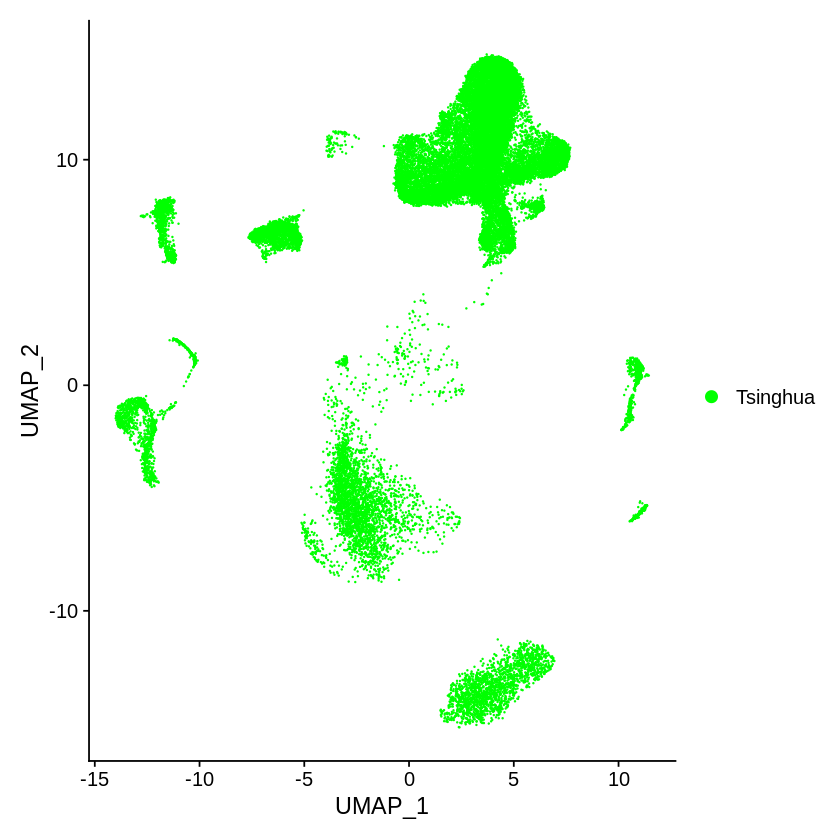

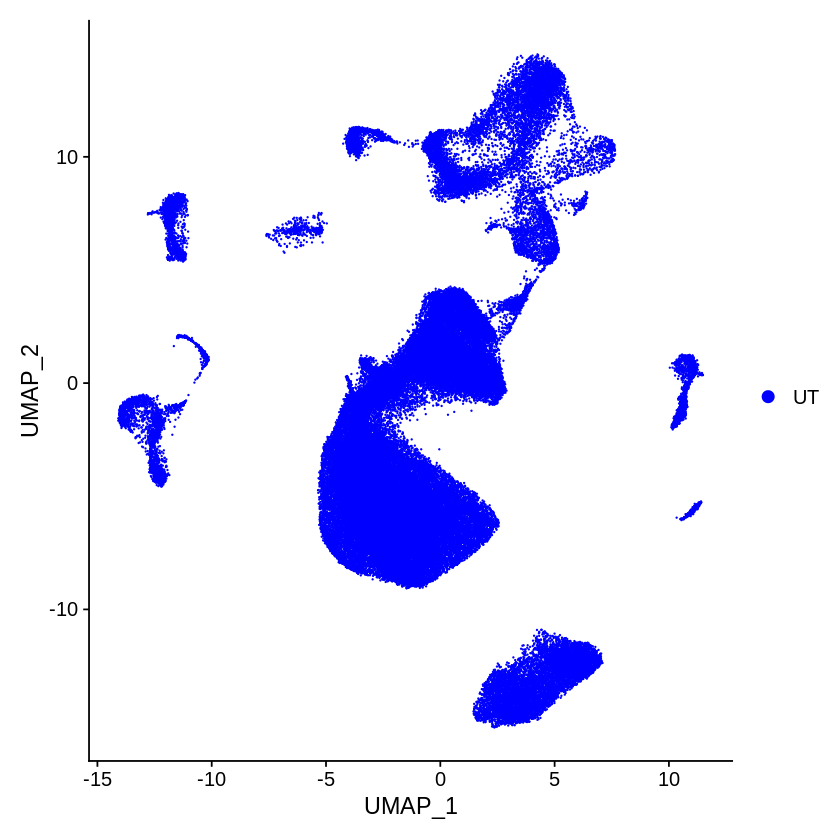

In [22]:
options(repr.plot.width=7, repr.plot.height=7)
DimPlot(subset(all,idents='Stanford'), group.by='institution',cols='red')
DimPlot(subset(all,idents='Tsinghua'), group.by='institution',cols='green')
DimPlot(subset(all,idents='UT'), group.by='institution',cols = 'blue')

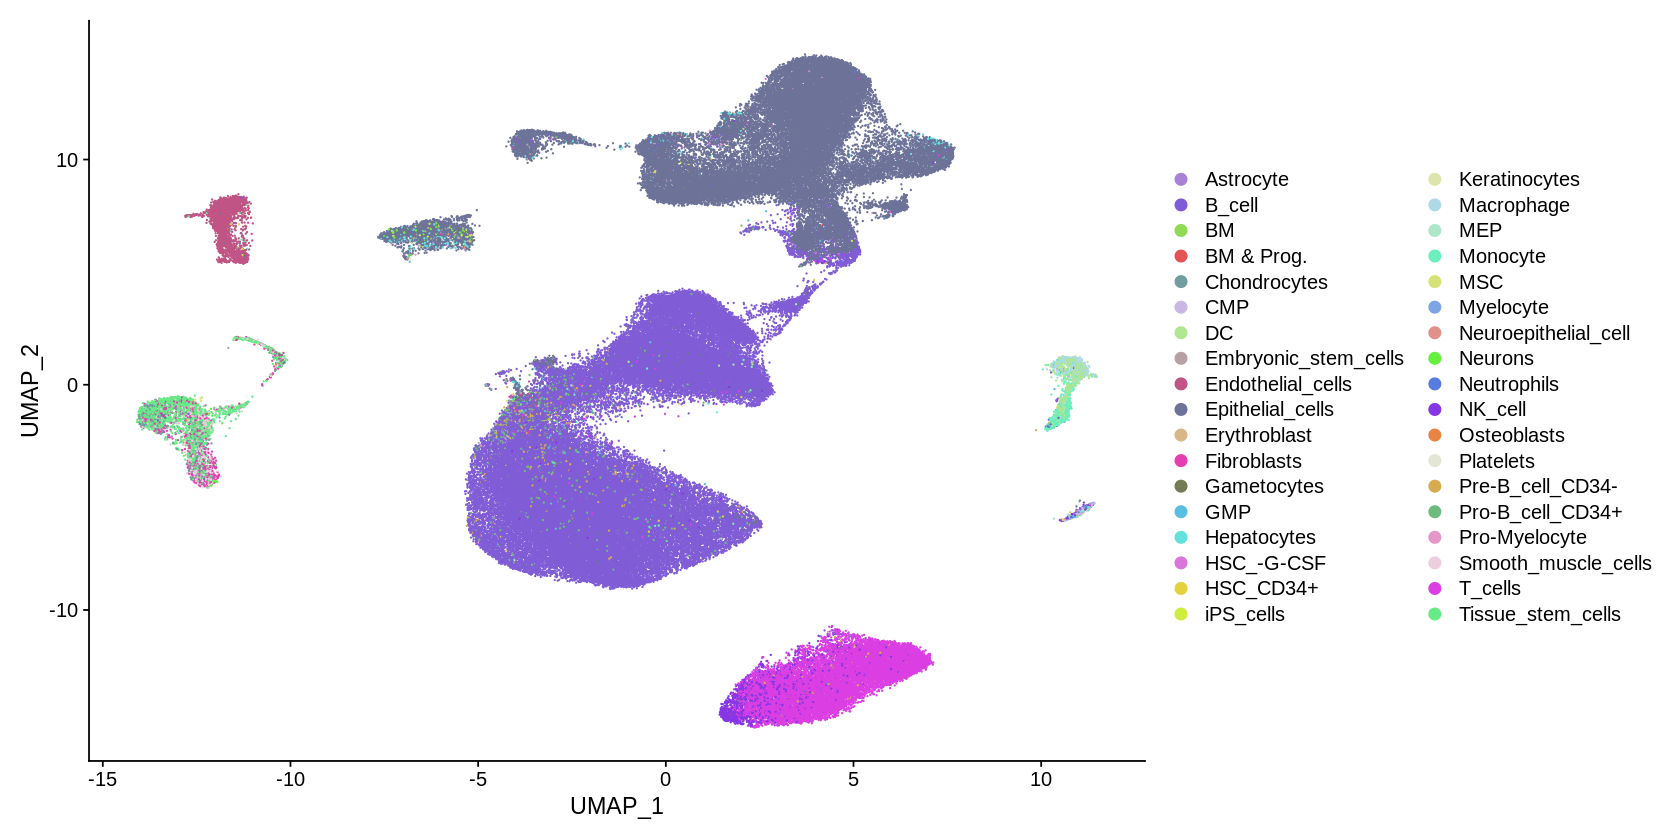

In [29]:
options(repr.plot.width=14, repr.plot.height=7)
DimPlot(all, group.by='celltype_singleR', cols = unlist(colors[length(unique(all@meta.data$celltype_singleR))]))

In [31]:
Idents(all) <- 'celltype_singleR'

In [32]:
marker.genes <- c('KRT19',
                 'MKI67',
                 'ATP4A',
                 'CHGA',
                 'MS4A1',
                 'CD79A',
                 'IGKC',
                 'IGHG1',
                 'CD3D',
                 'CD4',
                 'CD8A',
                 'CD14',
                 'ACTA2',
                 'COL3A1',
                 'VWF','TPSAB1')

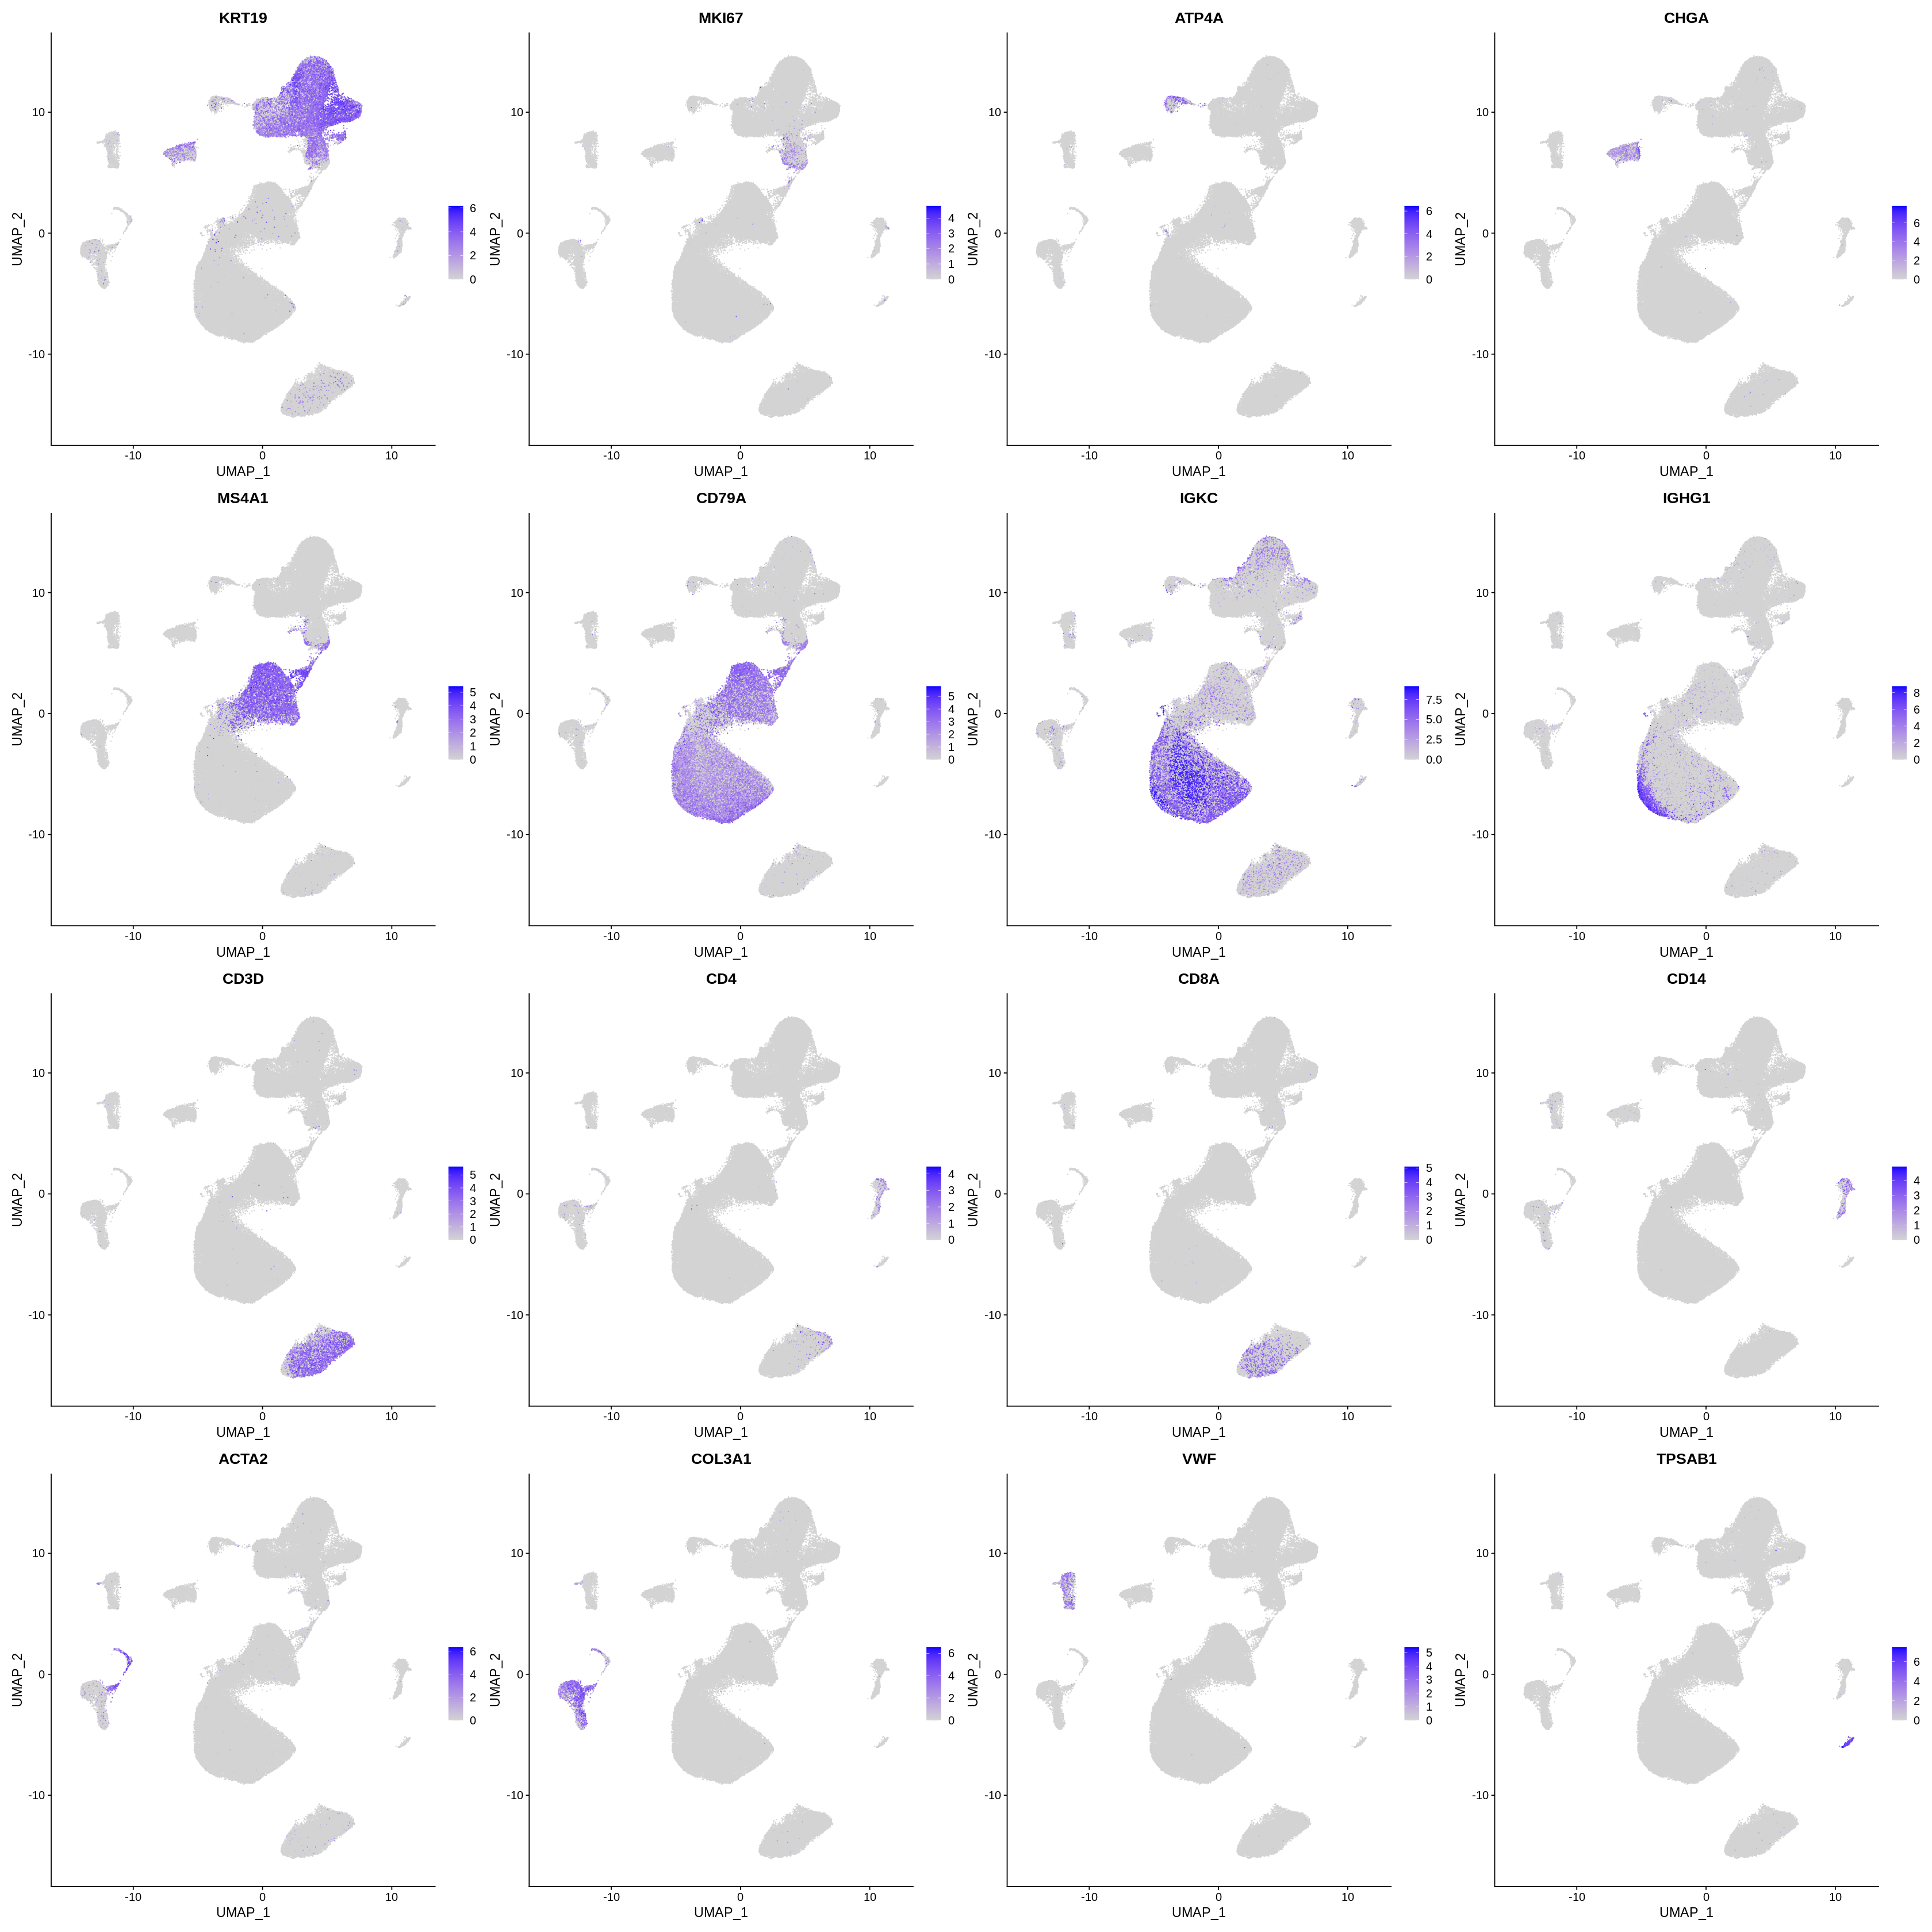

In [33]:
options(repr.plot.width=7*4, repr.plot.height=7*4)
FeaturePlot(all,features=marker.genes)

options(repr.plot.width=7, repr.plot.height=7)
FeaturePlot(all,features='ACTA2')
FeaturePlot(all,features='BARX1')
FeaturePlot(all,features='KRT19')

In [34]:
Idents(all) <- 'seurat_clusters'

## from here, manual annotation was performed
## (If you can use BBrowserX, BBrowserX is better to annotate the cell)

In [35]:
# you can see celltype_singleR in each seurat cluster i
cluster_table <- function(i){
    subset(all,idents = i)[[]]$celltype_singleR %>% table
}

cluster_identification <- function(i){
    a <- subset(all,idents = i)[[]]$celltype_singleR %>% table %>% as.data.frame
    print(a[a$Freq==a$Freq %>% max,]$.)
}


In [36]:
cluster_identification(10)

[1] Tissue_stem_cells
20 Levels: B_cell BM Chondrocytes CMP DC ... Tissue_stem_cells


In [61]:
cluster_table(25)

.
          B_cell Epithelial_cells              GMP Pre-B_cell_CD34- 
             103                1                2                1 
Pro-B_cell_CD34+ 
              21 

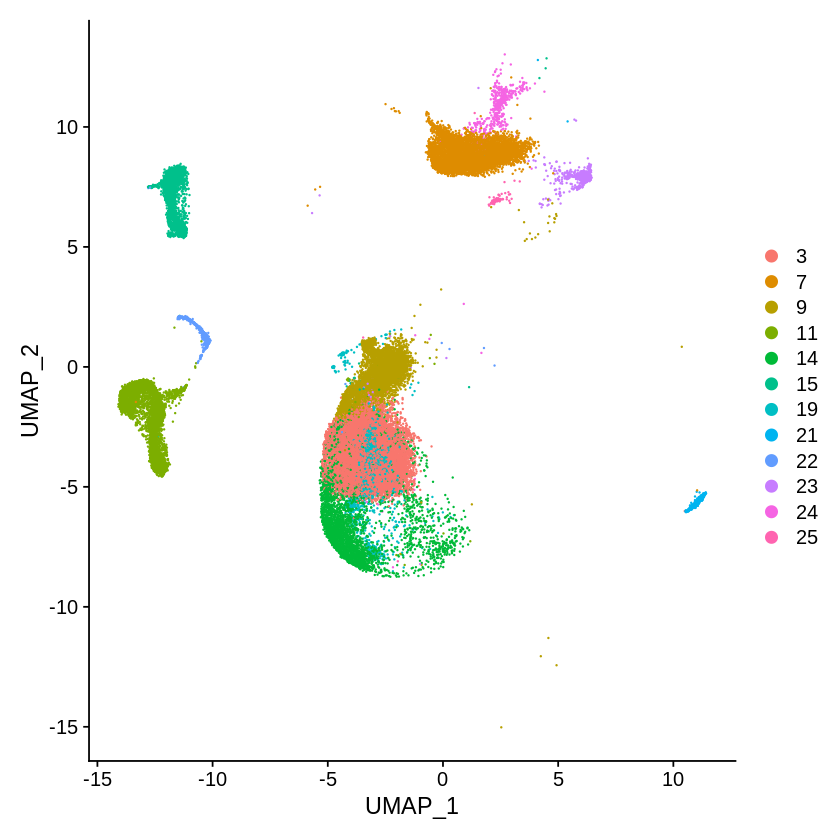

In [63]:
options(repr.plot.width=7, repr.plot.height=7)
DimPlot(subset(all,idents = c(3,7,9,11,14,15,19,21,22,23,24,25)))

In [65]:
all <- RenameIdents(all, '0'='B/plasma',
							'1'='B/plasma',
							'2'='epi', 
                            '3'='B/plasma',
                            '4'='B/plasma',
                            '5'='T',
                            '6'='T',
                            '7'='epi',
                            '8'='B/plasma',
                            '9'='B/plasma',
                            '10'='epi',
                            '11'='FB',
                            '12'='epi',
                            '13'='epi', 
                            '14'='B/plasma',
                            '15'='EC',
                            '16'='epi', #NE
                            '17'='Mp',
                            '18'='epi', #PC
                            '19'='B/plasma', #???
                            '20'='B/plasma', #soup?
                            '21'='mast',
                            '22'='FB', #SM
                            '23'='epi',
                            '24'='epi',
                            '25'='epi' #?
)

In [70]:
library(ggplot2)

In [72]:
#reorder clusters 
all@active.ident <- factor(all@active.ident, 
                            levels=rev(c("epi", 
                                         #'soup',
                                "B/plasma",
                                         'T',
                                     "Mp",
                                     "FB",  
                                     "EC", 
                                     "mast"))
                          )

In [73]:
marker.genes <- c('KRT19',
                 #'ATP4A',
                 #'CHGA',
                  'MS4A1',
                 'CD79A',
                 'IGKC',
                 'IGHG1',
                 'CD3D',
                 'CD4',
                 'CD8A',
                 'CD14',
                  'COL3A1',
                 'ACTA2',
                 'VWF','TPSAB1','MKI67')

In [74]:
rev(marker.genes)

[1] "MKI67"  "TPSAB1" "VWF"    "ACTA2"  "COL3A1" "CD14"   "CD8A"   "CD4"   
 [9] "CD3D"   "IGHG1"  "IGKC"   "CD79A"  "MS4A1"  "KRT19"

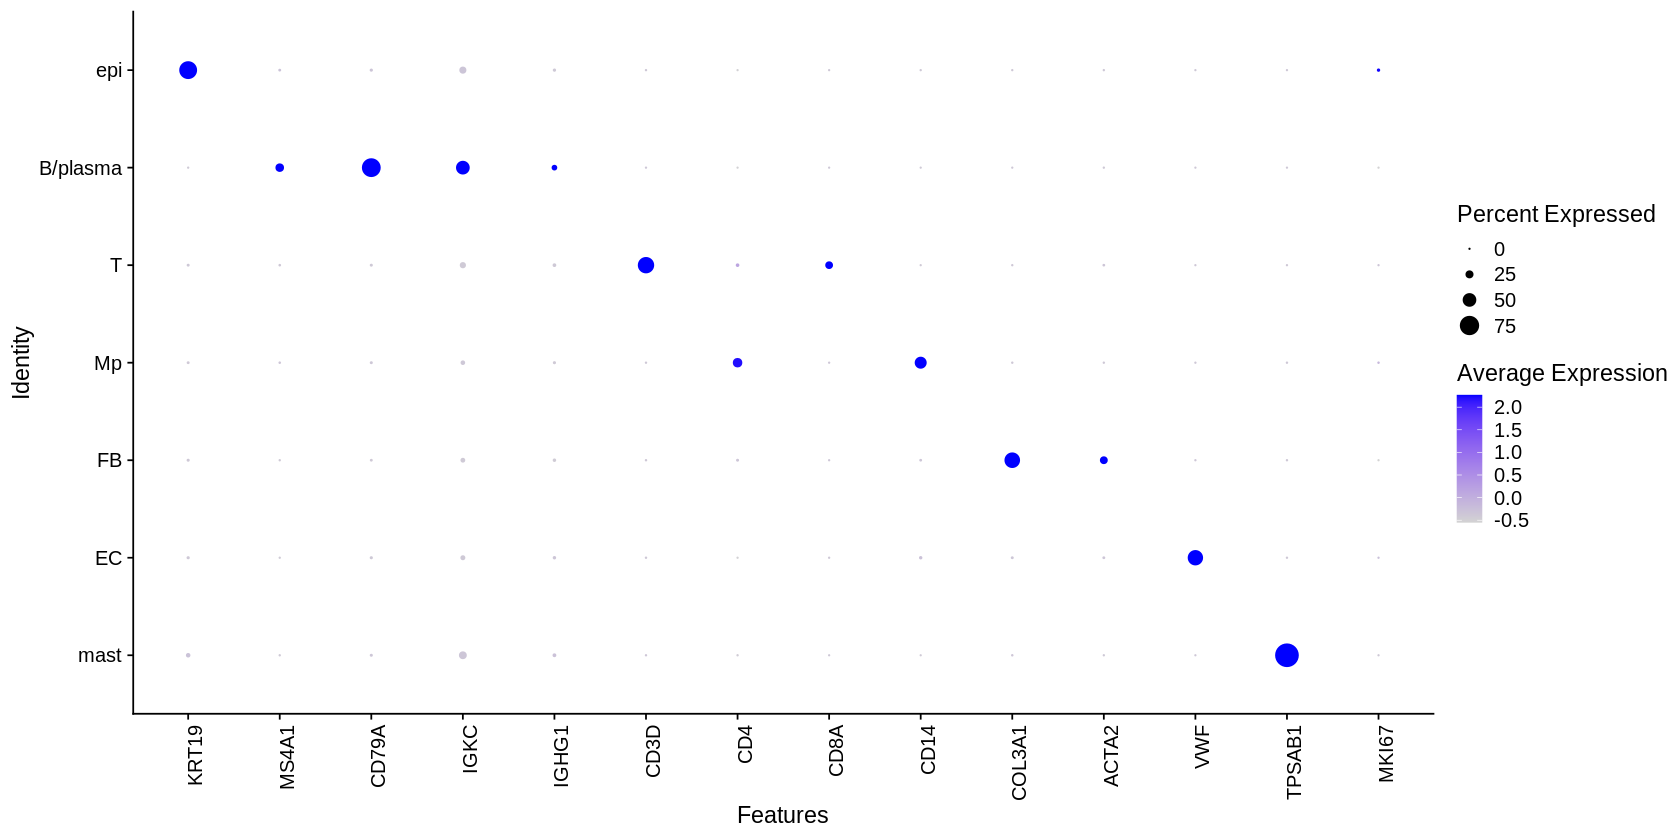

In [76]:
DotPlot(all, features = rev(marker.genes))+
theme(axis.text.x = element_text(angle = 90, hjust = 1))

### save the dataset annotated 

In [80]:
saveRDS(all,'data_1_0_seurat_major_clustered.rds')

In [81]:
lymphs <- c('B/plasma','T')
BM <- c('Mp')
Mast <- c('mast')
epi <- c('epi','soup')
FB <- c('FB')
EC <- c('EC')

In [82]:
Idents(all) %>% unique

[1] FB       epi      mast     T        B/plasma EC       Mp      
Levels: mast EC FB Mp T B/plasma soup epi

In [83]:
saveRDS(subset(all,idents=epi),'data_1_1_seurat_epi.rds')
saveRDS(subset(all,idents=lymphs),'data_1_2_seurat_lymphocyte.rds')
saveRDS(subset(all,idents=BM),'data_1_3_seurat_Mp.rds')
saveRDS(subset(all,idents=Mast),'data_1_4_seurat_Mast.rds')

In [84]:
saveRDS(subset(all,idents=FB),'data_1_5_seurat_FB.rds')
saveRDS(subset(all,idents=EC),'data_1_6_seurat_EC.rds')